In [1]:
import numpy as np
import pandas as pd
from scipy import special
from random import sample
import itertools
from datetime import timedelta
from IPython.display import display

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
!curl  https://caelum-online-public.s3.amazonaws.com/1368-modelos-preditivos-deteccao-fraude/base-de-dados.zip -O  > base-de-dados.zip
!unzip base-de-dados.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6999k  100 6999k    0     0  12.0M      0 --:--:-- --:--:-- --:--:-- 12.0M
Archive:  base-de-dados.zip
  inflating: Fraud_Data.csv          
  inflating: IpAddress_to_Country.csv  


In [4]:
fraude_df = pd.read_csv("Fraud_Data.csv", header=0)
ISP_df = pd.read_csv("IpAddress_to_Country.csv", header=0)

In [5]:
for col in fraude_df.columns:
    print("# de valores nulos em {}: {}".format(col, fraude_df[col].isnull().sum()))

# de valores nulos em id: 0
# de valores nulos em cadastro: 0
# de valores nulos em compra: 0
# de valores nulos em valor: 0
# de valores nulos em id_dispositivo: 0
# de valores nulos em fonte: 0
# de valores nulos em browser: 0
# de valores nulos em genero: 0
# de valores nulos em idade: 0
# de valores nulos em ip: 0
# de valores nulos em fraude: 0


In [6]:
for col in ISP_df.columns:
    print("{}: {}".format(col, ISP_df[col].dtype))

limite_inferior_ip: float64
limite_superior_ip: int64
pais: object


In [7]:
ip_floats = ISP_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print("Número de limites inferiores de endereço IP com decimal não-zero: {}".format(ip_floats))

Número de limites inferiores de endereço IP com decimal não-zero: 0


In [8]:
ISP_df.limite_inferior_ip = ISP_df.limite_inferior_ip.astype(np.int64)

In [9]:
for col in ISP_df.columns:
    print("# de valores nulos em {}: {}".format(col, ISP_df[col].isnull().sum()))

# de valores nulos em limite_inferior_ip: 0
# de valores nulos em limite_superior_ip: 0
# de valores nulos em pais: 0


In [10]:
display(ISP_df[ISP_df.limite_inferior_ip == ISP_df.limite_inferior_ip.max()])
display(ISP_df[ISP_df.limite_superior_ip == ISP_df.limite_superior_ip.max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3758096128,3758096383,Australia


In [11]:
fraude_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [12]:
def isp_counts(isp):
    pais = ISP_df[(ISP_df.limite_inferior_ip <= isp) & (ISP_df.limite_superior_ip >= isp)].pais

In [13]:
def isp_counts(isp):
    pais = ISP_df[(ISP_df.limite_inferior_ip <= isp) & (ISP_df.limite_superior_ip >= isp)].pais
    if pais.shape[0] == 1:
        return print("Único")
    elif pais.shape[0] > 1:
        return print("Vários países")
    elif pais.shape[0] == 0:
        if isp > ISP_df.limite_superior_ip.max():
            return print("Muito grande")
        elif isp < ISP_df.limite_inferior_ip.min(): #estava errado com _min
            return print("Muito pequeno")
        else:
            return print("Faltando")

ip_counts = fraude_df.ip.apply(isp_counts)
ip_counts.value_counts()

Streaming output truncated to the last 5000 lines.
Único
Faltando
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Muito pequeno
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Muito pequeno
Único
Único
Único
Muito grande
Único
Muito grande
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Muito grande
Único
Único
Únic

Series([], Name: ip, dtype: int64)

In [14]:
def ip_para_pais(ip):
    tmp = ISP_df[(ISP_df.limite_inferior_ip <= ip)
            & (ISP_df.limite_superior_ip >= ip)].pais
    if tmp.shape[0] == 1:
        return tmp.iloc[0]
    elif tmp.shape[0] < 1:
        return print("Faltando")
    elif tmp.shape[0] > 1:
        return print("Erro")

In [15]:
fraude_df["pais"] = fraude_df.ip.apply(ip_para_pais)
fraude_df.head()

Streaming output truncated to the last 5000 lines.
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Falt

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [16]:
fraude_df.to_csv("Dados_fraude_com_pais", index=False)
fraude_df = pd.read_csv("Dados_fraude_com_pais", header=0)
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Text(0, 0.5, 'Casos')

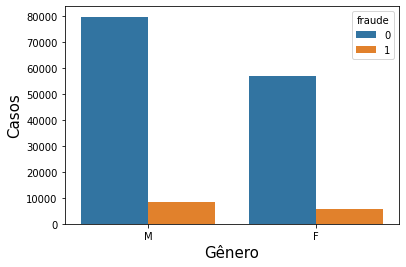

In [17]:
sns.countplot(x="genero", hue="fraude", data=fraude_df)
plt.xlabel("Gênero", fontsize=15)
plt.ylabel("Casos", fontsize=15)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.42499999999999716, 0.5, 'Valor de compra')

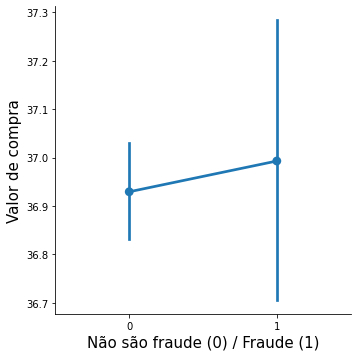

In [18]:
sns.factorplot(x="fraude", y="valor", data=fraude_df)
plt.xlabel("Não são fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("Valor de compra", fontsize=15)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(-5.825000000000003, 0.5, 'Idade')

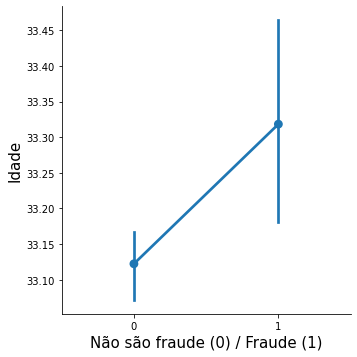

In [19]:
sns.factorplot(x="fraude", y="idade", data=fraude_df)
plt.xlabel("Não são fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("Idade", fontsize=15)

Text(0, 0.5, 'Contagem')

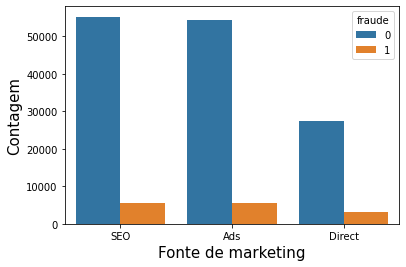

In [20]:
sns.countplot(x="fonte", hue="fraude", data=fraude_df)
plt.xlabel("Fonte de marketing", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

In [21]:
sums_f = fraude_df[fraude_df["fraude"] == 1]["fraude"].groupby(fraude_df.pais).sum()
sums_f = sums_f.to_frame().reset_index()

sums_nf = fraude_df[fraude_df["fraude"] == 0]["fraude"].groupby(fraude_df.pais).sum()
sums_nf = sums_nf.to_frame().reset_index()

Text(0, 0.5, 'Países')

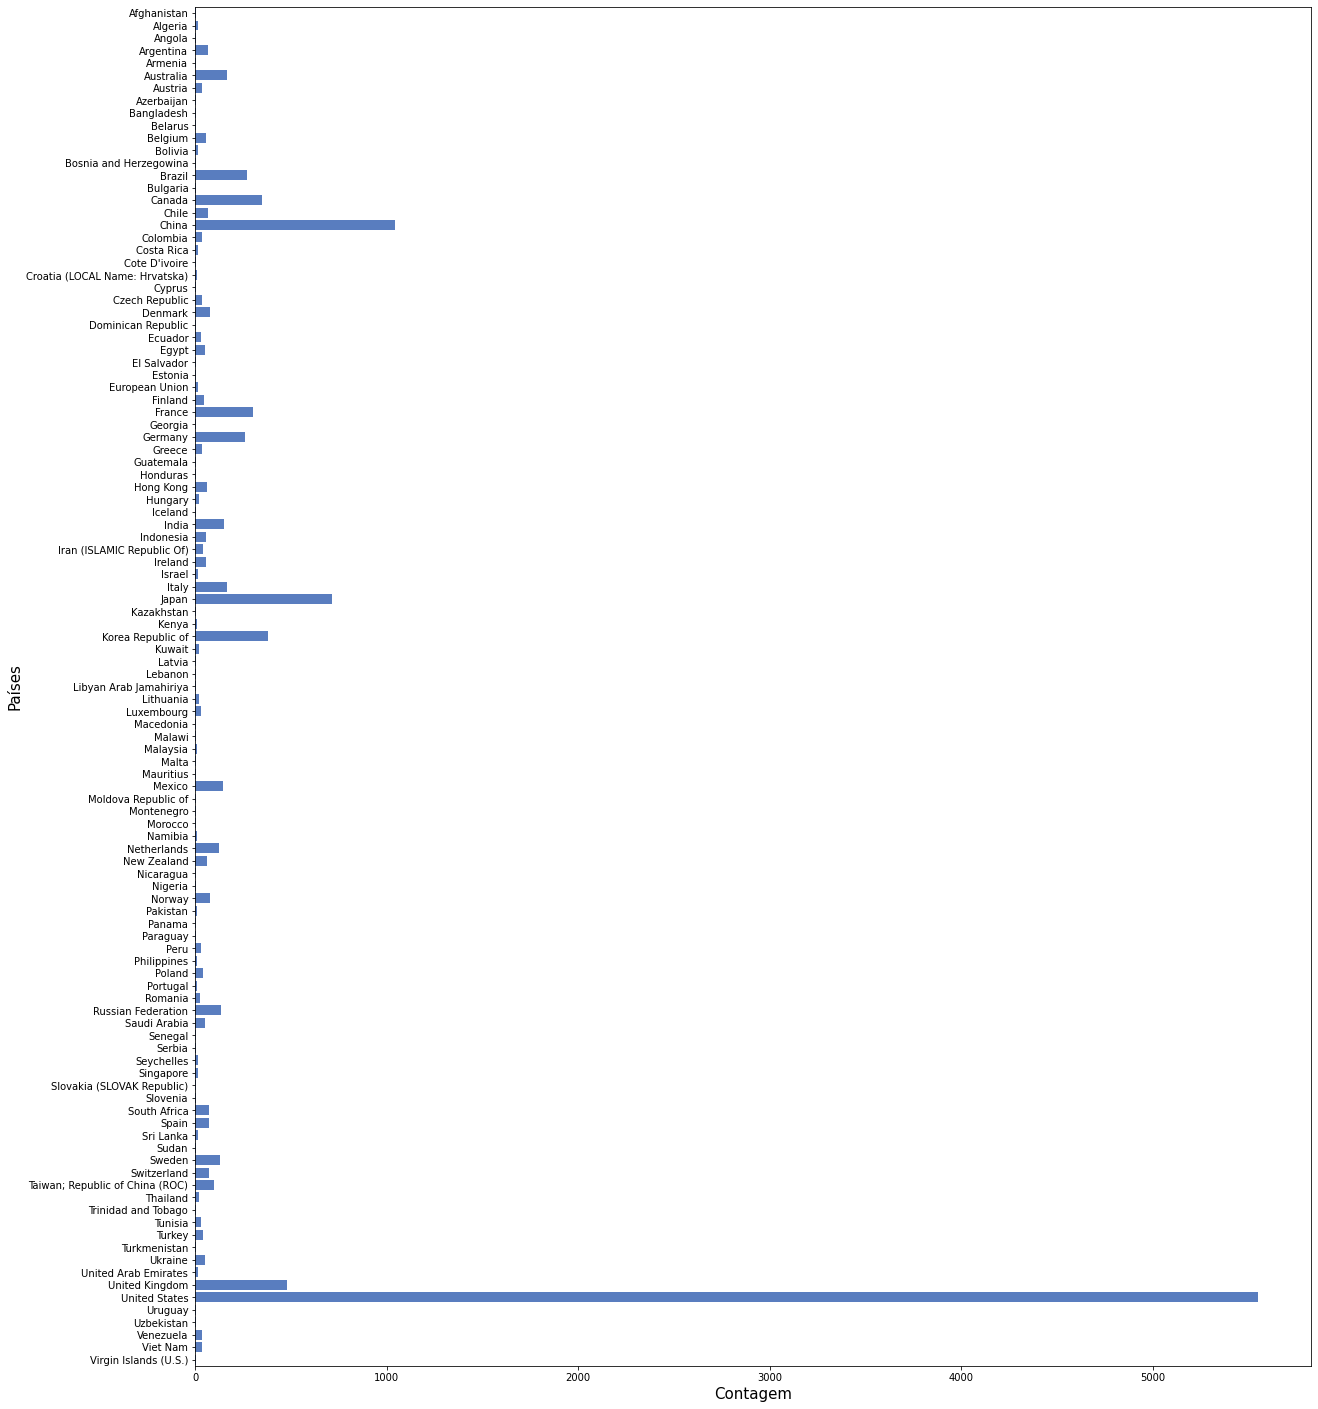

In [22]:
f, ax = plt.subplots(figsize=(20,25))
sns.set_color_codes("muted")
sns.barplot(x="fraude", y="pais", data=sums_f,
            label="Total", color="b")
plt.xlabel("Contagem",fontsize=15)
plt.ylabel("Países",fontsize=15)

In [23]:
tmp_df = pd.DataFrame(columns=("fraude","id_por_dispositivo","id_por_ip"))
tmp_df["fraude"] = fraude_df["fraude"]

userid_count = fraude_df.groupby("id_dispositivo").id.count()
tmp_df["id_por_dispositivo"] = fraude_df.id_dispositivo.apply(lambda x: userid_count[x])

userid_count2 = fraude_df.groupby("ip").id.count()
tmp_df["id_por_ip"] = fraude_df.ip.apply(lambda x: userid_count2[x])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(16.299999999999997, 0.5, 'ID de usuário por endereço IP')

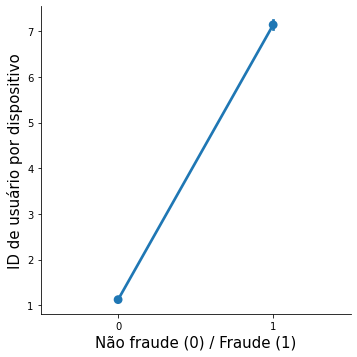

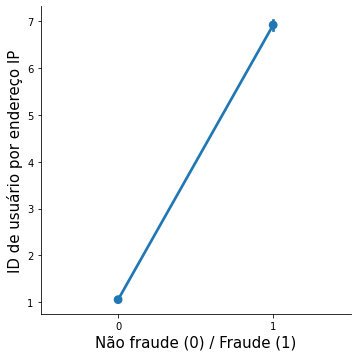

In [24]:
sns.factorplot(x="fraude", y="id_por_dispositivo", data=tmp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("ID de usuário por dispositivo", fontsize=15)

sns.factorplot(x="fraude", y="id_por_ip", data=tmp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("ID de usuário por endereço IP", fontsize=15)

In [25]:
tmp_df["cadastro"] = fraude_df.cadastro.apply(pd.to_datetime)
tmp_df["compra"] = fraude_df.compra.apply(pd.to_datetime)

tmp_df["tempo"] = (tmp_df.compra - tmp_df.cadastro).apply(lambda x: x.seconds)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(-8.825000000000003, 0.5, 'Tempo entre início e compra (segundos)')

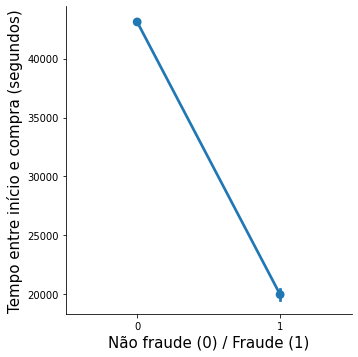

In [26]:
sns.factorplot(x="fraude", y="tempo", data=tmp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("Tempo entre início e compra (segundos)", fontsize=15)

Text(0, 0.5, 'Contagem')

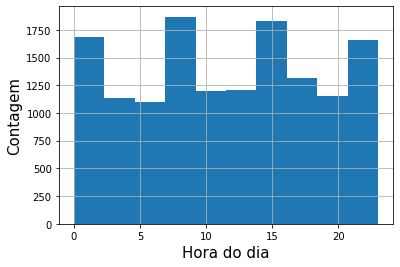

In [27]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.hour).hist()
plt.xlabel("Hora do dia", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Text(0, 0.5, 'Contagem')

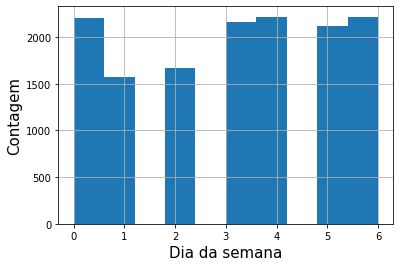

In [28]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Dia da semana", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Text(0, 0.5, 'Contagem')

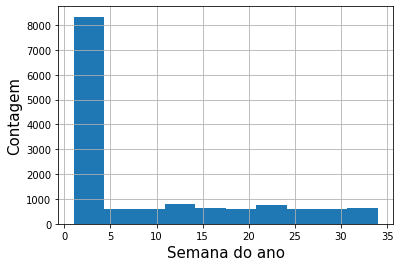

In [29]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.week).hist()
plt.xlabel("Semana do ano", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

In [30]:
userid_count3 = fraude_df.groupby("id_dispositivo").id.count()
fraude_df["id_por_dispositivo"] = fraude_df.id_dispositivo.apply(lambda x: userid_count3[x])

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1


In [31]:
userid_count4 = fraude_df.groupby("ip").id.count()
fraude_df["id_por_ip"] = fraude_df.ip.apply(lambda x: userid_count4[x])

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1


In [32]:
fraude_df["media_id"] = (fraude_df.id_por_dispositivo + fraude_df.id_por_ip) * 0.5

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0


In [33]:
fraude_df.cadastro = fraude_df.cadastro.apply(pd.to_datetime)
fraude_df.compra = fraude_df.compra.apply(pd.to_datetime)
fraude_df["tempo"] = (fraude_df.compra - fraude_df.cadastro).apply(lambda x: x.seconds)

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id,tempo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461


In [34]:
pais_dummies = pd.get_dummies(fraude_df.pais, prefix='pais')
fraude_df = pd.concat([fraude_df, pais_dummies], axis=1)

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,1,0,0,0,0,0,0,0,0,0


In [35]:
fraude_df.drop(["id",
            "cadastro",
            "compra",
            "id_dispositivo",
            "ip",
            "id_por_dispositivo",
            "id_por_ip",
            "pais",
            "fonte",
            "browser",
            "genero",
            "idade",
            "valor"], axis=1, inplace = True)

Text(0, 0.5, 'Contagem normalizada')

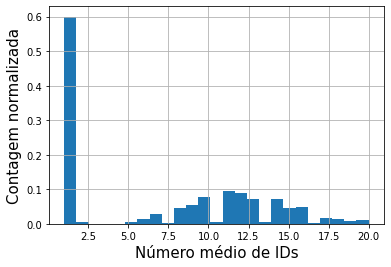

In [36]:
fraude_df[fraude_df["fraude"] == 1].media_id.hist(density=True, bins=25)
plt.xlabel("Número médio de IDs", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

Text(0, 0.5, 'Contagem normalizada')

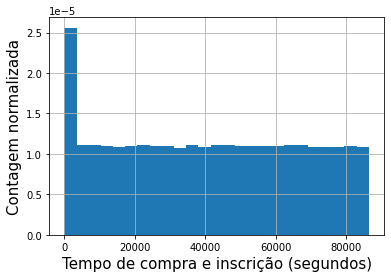

In [37]:
fraude_df.tempo.hist(density=True, bins=25)
plt.xlabel("Tempo de compra e inscrição (segundos)", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

In [38]:
def rescale_series(ser):
    ser_min = ser.min()
    ser_max = ser.max()
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    return new_ser

Text(0, 0.5, 'Contagem normalizada')

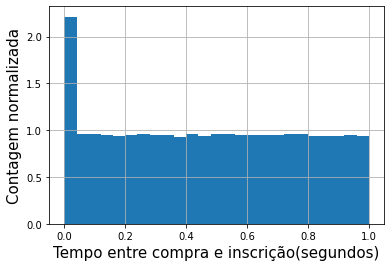

In [39]:
fraude_df["tempo"] = rescale_series(fraude_df.tempo)
fraude_df.tempo.hist(density=True, bins=25)
plt.xlabel("Tempo entre compra e inscrição(segundos)", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

In [40]:
onehotencoded = [feature for feature in fraude_df.columns if "pais" not in feature and feature !="fraude"]

X = fraude_df[ [col for col in fraude_df.columns if col != "fraude"]]
Y = fraude_df["fraude"]

In [41]:
X.to_csv("X.csv", index=False)
Y.to_csv("Y.csv", index=False)

In [42]:
X.head()

,media_id,tempo,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,1.0,0.160663,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.207678,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,12.0,0.000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1.0,0.695433,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.479872,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [43]:
X.index = range(len(X))
Y.index = range(len(Y))

In [44]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()
_ = clf.fit(X,Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_

features [features.importancia > np.mean(features.importancia)].sort_values(by="importancia", ascending=False)

,feature,importancia
1,tempo,0.571975
0,media_id,0.418399


In [45]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

In [46]:
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size = 0.75, random_state = 23)
Y_dev = Y_dev.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

In [47]:
IF = IsolationForest(max_samples="auto",contamination = 0.095, random_state=1)
param_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}

clf = GridSearchCV(IF,
                   param_grid,
                   cv=2,
                   n_jobs=3,
                   scoring="f1",
                   verbose=10)

_ = clf.fit(X_dev, Y_dev)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


              precision    recall  f1-score   support

     anomalo       0.42      0.43      0.42      3546
      normal       0.94      0.94      0.94     34232

    accuracy                           0.89     37778
   macro avg       0.68      0.68      0.68     37778
weighted avg       0.89      0.89      0.89     37778

Área sob a curva ROC: 0.683


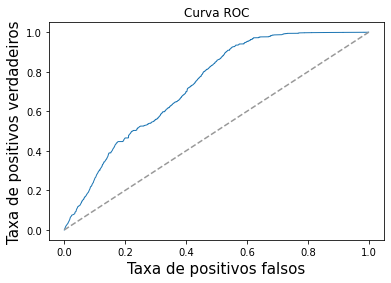

In [48]:
IF_best = clf.best_estimator_
Y_predicted = IF_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval,Y_predicted)

print(classification_report(Y_eval,
                           Y_predicted,
                           target_names=["anomalo","normal"]))
print("Área sob a curva ROC: {:0.3f}".format(roc_auc))

IF_probs = IF_best.decision_function(X_eval)
fpr, tpr, thresold = roc_curve(Y_eval, IF_probs)

plt.plot(fpr, tpr, lw = 1)

plt.plot([0,1],[0,1], '--', color=(0.6, 0.6, 0.6), label="sorte")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel("Taxa de positivos falsos", fontsize=15)
plt.ylabel("Taxa de positivos verdadeiros", fontsize=15)
plt.title("Curva ROC", fontsize=12)

plt.show()

In [49]:
from sklearn.metrics import confusion_matrix
cnf_matrix_IF = confusion_matrix(Y_eval, Y_predicted)
print(cnf_matrix_IF)

[[ 1512  2034]
 [ 2089 32143]]


In [50]:
X["fraude"] = Y

X_anomalias = X[X['fraude'] == 1]
X_normal = X[X['fraude'] == 0]

train_idxs = sample(list(X_normal.index), int(0.7* X_normal.shape[0]))
X_train = X_normal.loc[train_idxs]

X_testing = X_normal.drop(train_idxs)

X_testing = pd.concat([X_testing, X_anomalias], axis=0)

X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

Y_testing = X_testing['fraude']
X_testing = X_testing[ [ col for col in X_testing.columns if col != 'fraude']]

X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size = 0.7, random_state=23)

Y_cv = Y_cv.apply(lambda x: 1 if x==0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x ==0 else -1)

X_train = X_train[ [col for col in X_testing.columns if col !='fraude']]

In [51]:
param_grid = {"nu": np.linspace(0.001, 0.01, 5), "gamma": [0.01, 0.03, 0.1, 0.3]}
param_list = list(itertools.product(param_grid["nu"],param_grid["gamma"]))

In [52]:
from sklearn.svm import OneClassSVM

def random_gridsearch(param_list, n_sample, X_train, X_cv, Y_cv):
    
    f1_max = 0
    param_list = sample(param_list, n_sample)
    remaining_fits = n_sample
    for params in param_list:
        nu, gamma = params
        OCSVM = OneClassSVM(kernel="rbf", nu = nu, gamma=gamma )
        print('Fitando modelo...')
        OCSVM.fit(X_train)
        
        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average="binary")
        
        if f1 > f1_max:
            f1_max = f1
            OCSVN_best = OCSVM
        
            remaining_fits -=1
        
    return f1_max, OCSVM
    
f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...


              precision    recall  f1-score   support

    anormais       0.95      0.54      0.69      4211
     normais       0.86      0.99      0.92     12361

    accuracy                           0.88     16572
   macro avg       0.91      0.77      0.81     16572
weighted avg       0.89      0.88      0.86     16572

Área sob a curva ROC: 0.766


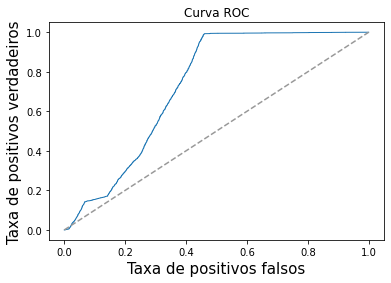

In [53]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval,Y_predicted)

print(classification_report(Y_eval,
                           Y_predicted,
                           target_names=['anormais','normais']))
print('Área sob a curva ROC: {:0.3f}'.format(roc_auc))

OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, thresholds = roc_curve(Y_eval, OCSVM_probs)

plt.plot(fpr,tpr, lw=1, label='ROC')
plt.plot([0,1],[0,1],'--', color=(0.6, 0.6, 0.6),label='sorte')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros',fontsize=15)
plt.title('Curva ROC')

plt.show()

In [54]:
print(confusion_matrix(Y_eval,Y_predicted))

[[ 2277  1934]
 [  111 12250]]


              precision    recall  f1-score   support

    anormais       0.95      0.88      0.92      4211
     normais       0.96      0.99      0.97     12361

    accuracy                           0.96     16572
   macro avg       0.96      0.93      0.94     16572
weighted avg       0.96      0.96      0.96     16572

Área sob a curva ROC: 0.934


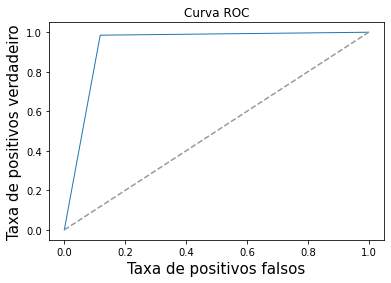

In [55]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_dev,Y_dev)

Y_predicted = decision_tree.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

cv_preds = decision_tree.predict(X_cv)
print(classification_report(Y_eval,
                           Y_predicted,
                           target_names=['anormais','normais']))

print('Área sob a curva ROC: {:0.3f}'.format(roc_auc))

dt_probs = decision_tree.predict_proba(X_eval)
fpr, tpr, _ = roc_curve(Y_eval, Y_predicted)

plt.plot(fpr, tpr, lw=1, label='ROC')

plt.plot([0,1],[0,1],'--',color=(0.6,0.6,0.6),label='sorte')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('Taxa de positivos falsos',fontsize=15)
plt.ylabel('Taxa de positivos verdadeiro',fontsize=15)

plt.title('Curva ROC')

plt.show()

In [56]:
print(confusion_matrix(Y_eval,Y_predicted))

[[ 3714   497]
 [  184 12177]]
